In [18]:
import pandas as pd

x_train = pd.read_csv('Dataset/x_train_all.csv')
y_train = pd.read_csv('Dataset/y_train_all.csv')

merged_df = pd.concat([x_train, y_train], axis=1)



In [19]:
data = x_train.iloc[1:9690]

x_train.iloc[:1]

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,87.0,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0


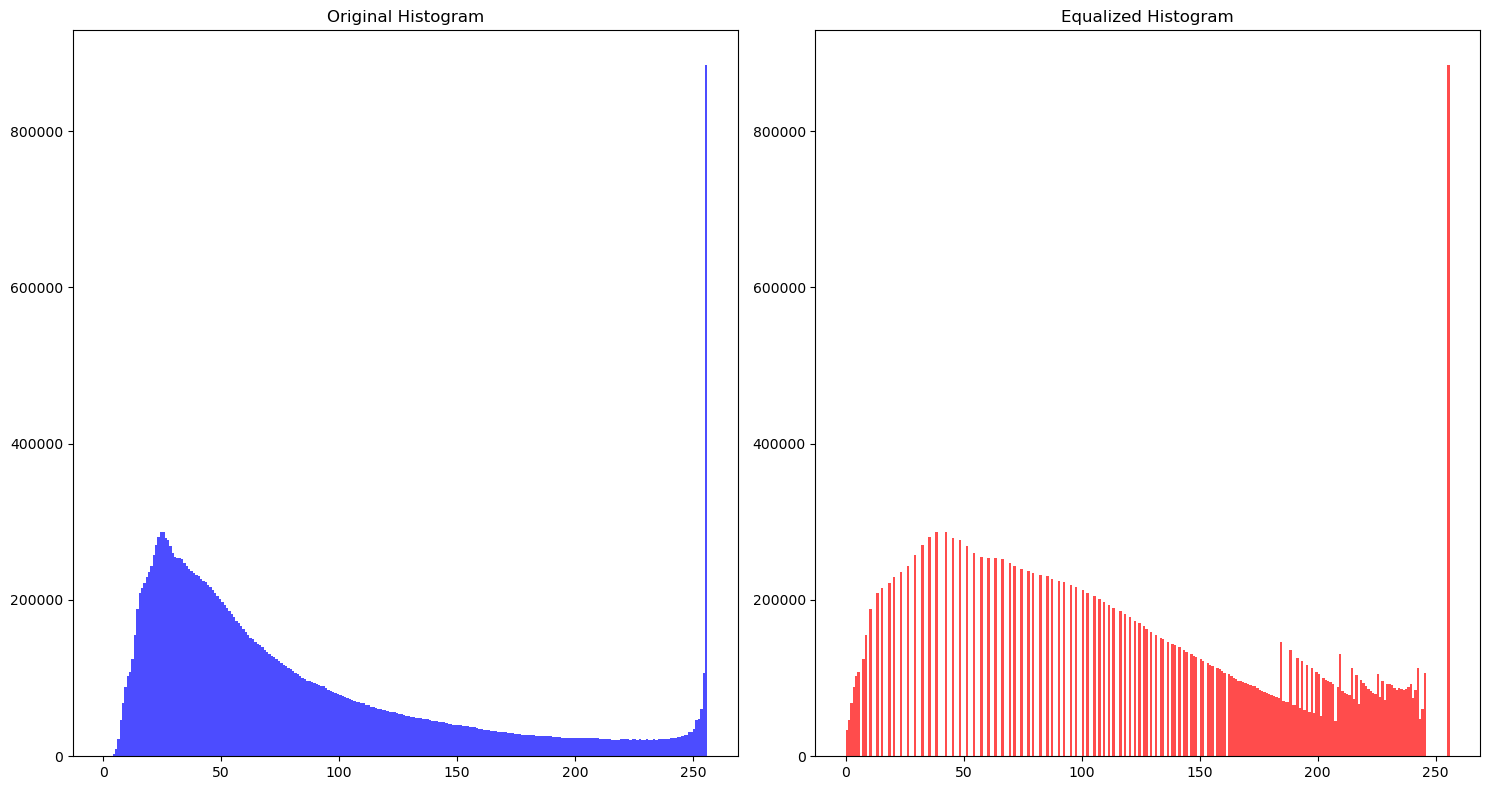

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_data = np.array(data, dtype=np.uint8)

equalized_image = cv2.equalizeHist(image_data)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(equalized_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Equalized Histogram')

plt.tight_layout()
plt.show()

In [4]:
#Contrast Limited Adaptive Histogram Equalization 
def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

def brighten(row, target_mean_brightness=128, max_brightness_adjustment=50):
    current_mean_brightness = np.mean(row)
    brightness_adjustment = target_mean_brightness - current_mean_brightness
    brightness_adjustment = np.clip(brightness_adjustment, -max_brightness_adjustment, max_brightness_adjustment)
    scaling_factor = (current_mean_brightness + brightness_adjustment) / current_mean_brightness
    adjusted_row = row * scaling_factor
    adjusted_row[adjusted_row < 0] = 0
    adjusted_row[adjusted_row > 255] = 255
    return adjusted_row


def apply_gamma_correction(row, gamma=1.8):
    input_shape = row.shape
    row = np.array(row, dtype=np.uint8)
    corrected_row = ((row / 255.0) ** (1 / gamma) * 255).astype(np.uint8)
    corrected_row = corrected_row.reshape(*input_shape) 
    return corrected_row

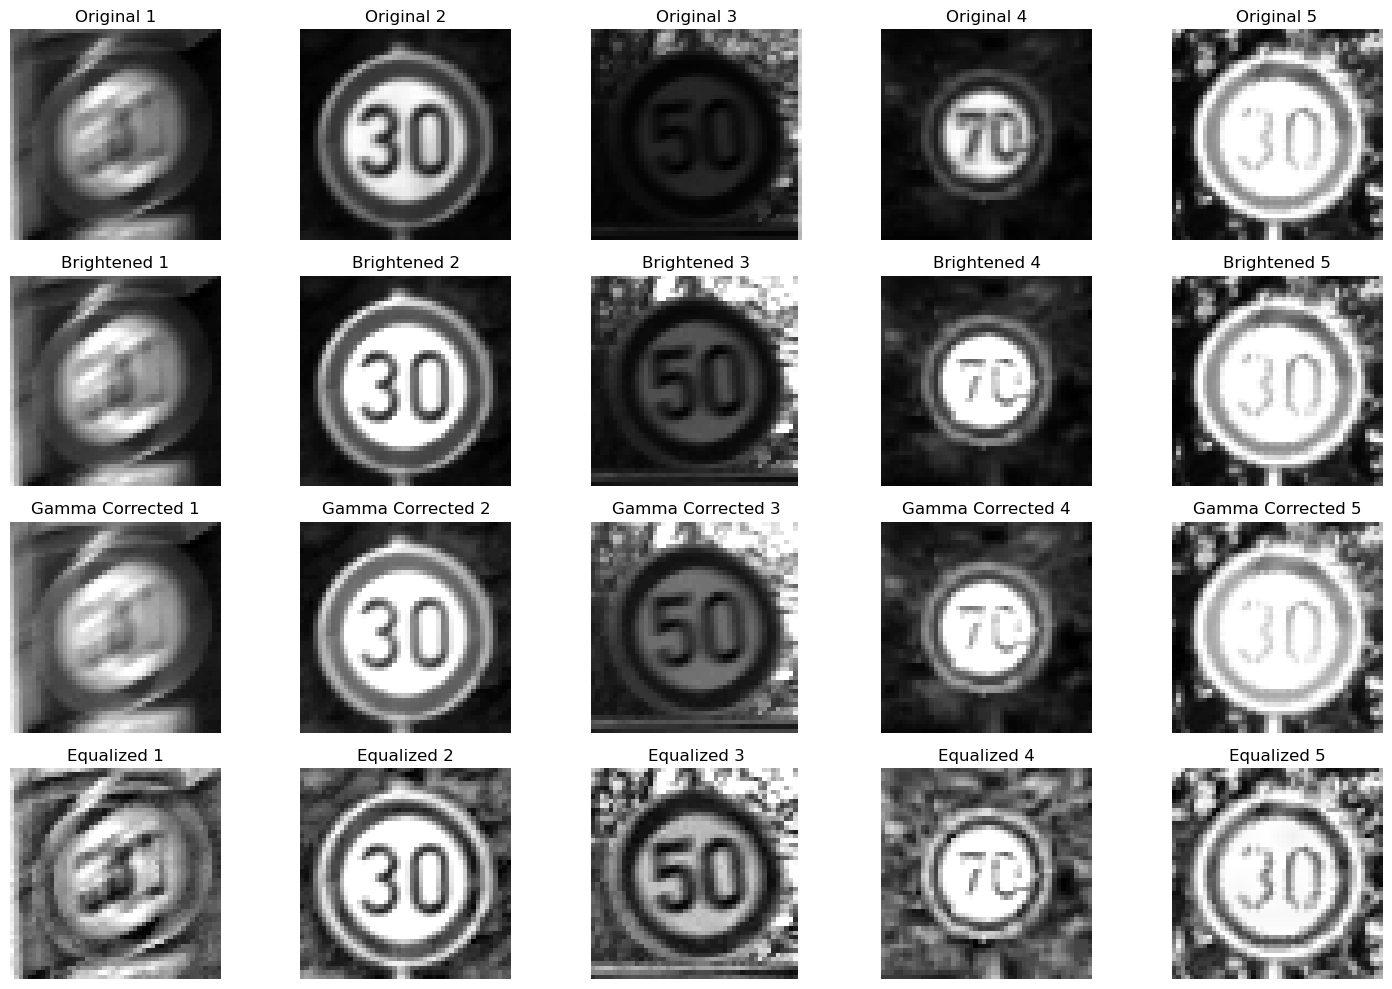

In [5]:

x_copy = x_train.copy()

sample_size = 5
sample_indices = x_copy.sample(sample_size).index


plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    plt.subplot(4, sample_size, i + 1)
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    brightened_image = brighten(x_copy.iloc[idx].values)
    plt.subplot(4, sample_size, sample_size + i + 1)
    brightened_image = brightened_image.reshape(48, 48)
    plt.imshow(brightened_image, cmap='gray')
    plt.title(f'Brightened {i+1}')
    plt.axis('off')

    gamma_image = apply_gamma_correction(brightened_image)
    plt.subplot(4, sample_size, 2*sample_size + i + 1)
    plt.imshow(gamma_image, cmap='gray')
    plt.title(f'Gamma Corrected {i+1}')
    plt.axis('off')

    equalized_image = apply_clahe(gamma_image)
    plt.subplot(4, sample_size, 3*sample_size + i + 1)
    plt.imshow(equalized_image, cmap='gray')
    plt.title(f'Equalized {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
processed_images = []

sample_size = 5
sample_indices = x_copy.sample(sample_size).index

for i, idx in enumerate(sample_indices):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)

    processed_images.append(equalized_image.flatten())

processed_df_subset = pd.DataFrame(processed_images)
processed_df_subset.shape

(5, 2304)

In [7]:
processed_images = []

for i, idx in enumerate(x_copy.index):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)
    processed_images.append(equalized_image.flatten())

processed_df = pd.DataFrame(processed_images)
processed_df.shape

(9690, 2304)

In [8]:
x_train.shape

(9690, 2304)

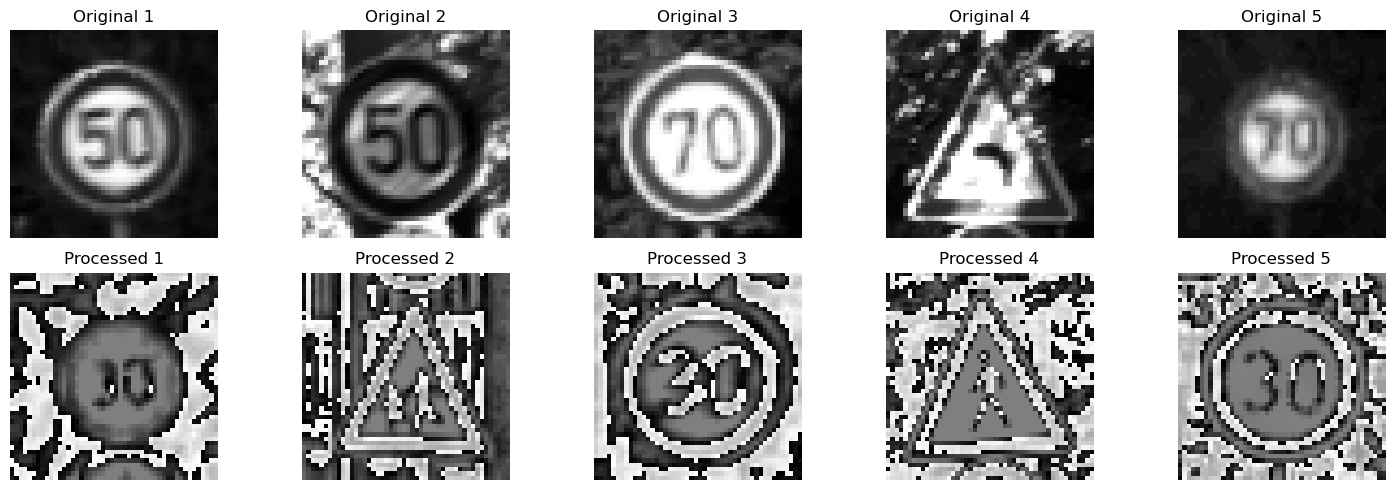

In [9]:

x_train_reset = x_copy.reset_index(drop=True)
sample_size = 5
sample_indices = x_copy.sample(sample_size).index
plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    original_image = x_train_reset.iloc[idx].values.reshape(48, 48)
    processed_image = processed_df_subset.iloc[i].values.reshape(48, 48)

    plt.subplot(2, sample_size, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(2, sample_size, sample_size + i + 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title(f'Processed {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
merged_df.shape

(9690, 2305)

In [11]:
# merged_df.to_csv("merged_df.csv")

In [12]:
# processed_df.to_csv("processed_df.csv")

In [13]:
processed_df.shape

(9690, 2304)

In [14]:
y_train.shape

(9690, 1)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 22

X_train, X_test, Y_train, Y_test = train_test_split(processed_df, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5259717922256621
F1 Score: 0.505946261779949
Confusion Matrix:
 [[ 46 152  55  49  63   4   2   0   0   3]
 [ 11 307 178  55  89   0   0   0   0   0]
 [  5  90 282  18  50   0   0   0   0   0]
 [  1  31  52 217  32   1   1   1   7   5]
 [  1  84  68  52 327   0   0   0   0   0]
 [  0   1   0   0   1  47   3   3   7   5]
 [  1   4  14  20  13   5  67   1  17   5]
 [  0   1   0   0   1   0   0  51   0   0]
 [  0   0   0   0   0   3   2   0 133   7]
 [  0  16  15   9   7   5  29   9  14  52]]


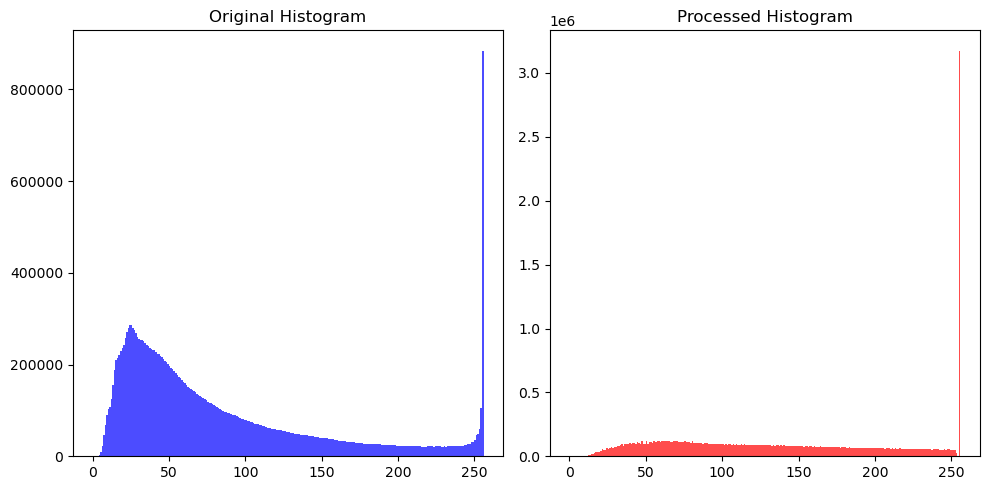

In [54]:
image_data = np.array(data, dtype=np.uint8)

processed_image = apply_clahe(apply_gamma_correction(brighten(image_data)))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [55]:
# Z normalization to preprocessed data
mean=processed_df.mean()
std=processed_df.std()
processed_df_norm=(processed_df-mean)/std

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 22

X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(processed_df_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_norm, Y_train_norm)

predicted = gnb.predict(X_test_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
accuracy = accuracy_score(predicted, Y_test_norm)
f1 = f1_score(predicted, Y_test_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5259717922256621
F1 Score: 0.505946261779949
Confusion Matrix:
 [[ 46 152  55  49  63   4   2   0   0   3]
 [ 11 307 178  55  89   0   0   0   0   0]
 [  5  90 282  18  50   0   0   0   0   0]
 [  1  31  52 217  32   1   1   1   7   5]
 [  1  84  68  52 327   0   0   0   0   0]
 [  0   1   0   0   1  47   3   3   7   5]
 [  1   4  14  20  13   5  67   1  17   5]
 [  0   1   0   0   1   0   0  51   0   0]
 [  0   0   0   0   0   3   2   0 133   7]
 [  0  16  15   9   7   5  29   9  14  52]]


In [58]:
# Outlier mining to processed data

from sklearn.ensemble import IsolationForest

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(processed_df)

outlier_indices = processed_df.index[outliers == -1]

x_train_no_outliers = processed_df.drop(outlier_indices)
y_train_no_outliers = y_train.loc[x_train_no_outliers.index]

print(x_train_no_outliers.shape)
y_train_no_outliers.shape

(9593, 2304)


(9593, 1)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train_out, X_test_out, Y_train_out, Y_test_out = train_test_split(x_train_no_outliers, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_out, Y_train_out)

predicted = gnb.predict(X_test_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
accuracy = accuracy_score(predicted, Y_test_out)
f1 = f1_score(predicted, Y_test_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5156358582348853
F1 Score: 0.49816528399840854
Confusion Matrix:
 [[ 43 152  45  41  59   1   0   0   0   1]
 [ 13 290 141  46  87   0   0   0   0   1]
 [  3  99 281  28  35   0   0   0   0   1]
 [  1  29  70 201  40   0   2   0   4   8]
 [  2  72  96  55 330   0   1   0   0   0]
 [  0   1   4   0   4  48   2   0   8   4]
 [  0   3  18  21  14   5  61   3  23   5]
 [  0   1   1   0   1   1   3  56   1   1]
 [  0   0   2   0   0   5   3   0 115   5]
 [  0  10  11  20   9   9  36  13  14  59]]


In [61]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5156358582348853
F1 Score: 0.49816528399840854
Confusion Matrix:
 [[ 43 152  45  41  59   1   0   0   0   1]
 [ 13 290 141  46  87   0   0   0   0   1]
 [  3  99 281  28  35   0   0   0   0   1]
 [  1  29  70 201  40   0   2   0   4   8]
 [  2  72  96  55 330   0   1   0   0   0]
 [  0   1   4   0   4  48   2   0   8   4]
 [  0   3  18  21  14   5  61   3  23   5]
 [  0   1   1   0   1   1   3  56   1   1]
 [  0   0   2   0   0   5   3   0 115   5]
 [  0  10  11  20   9   9  36  13  14  59]]


In [64]:
no_out_processed_df_norm.shape

(9593, 2304)

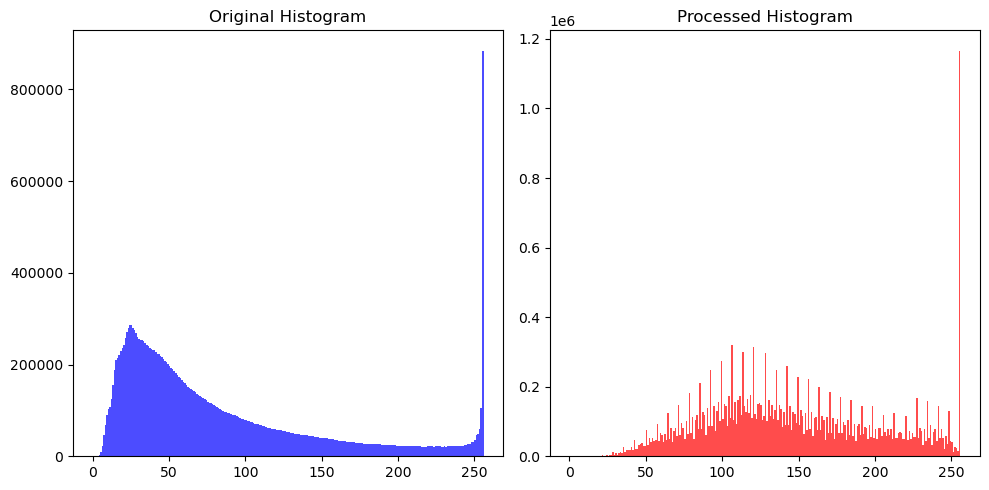

In [65]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [66]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 26

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5069492703266157
F1 Score: 0.48815049787586706
Confusion Matrix:
 [[ 40 140  50  56  59   1   0   0   0   1]
 [ 12 272 144  40  98   0   0   0   0   0]
 [  5  84 268  23  50   0   0   0   0   0]
 [  1  28  69 216  53   1   2   2   6   6]
 [  2  85  89  38 338   0   1   0   0   0]
 [  0   0   4   0   0  50   6   4   3   1]
 [  0  12  33  27  23   7  69   4  18   6]
 [  0   0   1   0   0   2   1  51   0   0]
 [  0   0   2   0   0   3   5   0 106   7]
 [  0  12  21  15   4   8  18   7  19  49]]


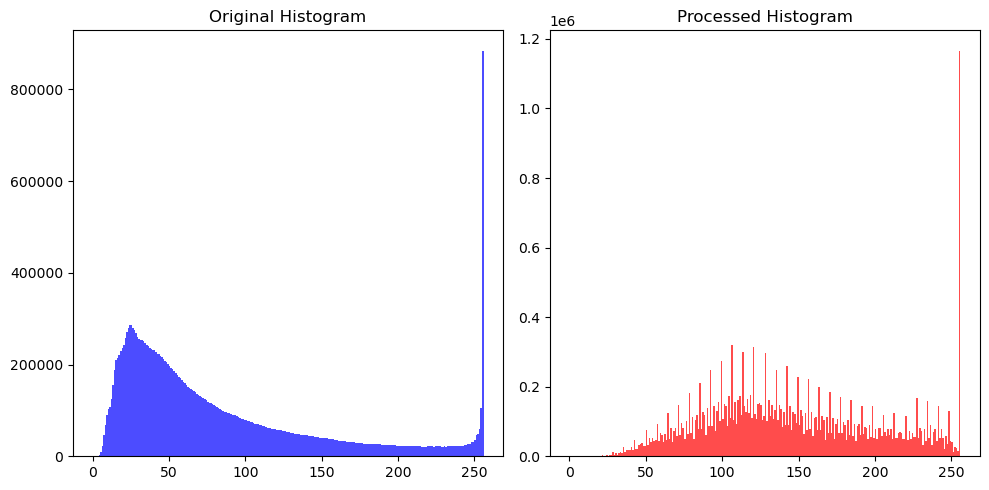

In [69]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

#### Different Naive Bayes model

In [116]:
#raw data 
from sklearn.naive_bayes import MultinomialNB
seed_value=75
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train, Y_train)

predicted = bayesClf.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [117]:
bayesPredictions = bayesClf.predict(X_test)
bayesAcc = accuracy_score(Y_test, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.3722050223598211


In [122]:
processed_df
negative_values = (processed_df < 0)

# Use 'any' to check if there are any negative values in each column
negative_in_columns = negative_values.any()

# Print which columns have negative values
print("Columns with negative values:")
print(negative_in_columns)


Columns with negative values:
0       True
1       True
2       True
3       True
4       True
        ... 
2299    True
2300    True
2301    True
2302    True
2303    True
Length: 2304, dtype: bool


In [132]:
Xmin=processed_df.min()
Xmax=processed_df.max()

In [133]:
X = (processed_df - Xmin)/(Xmax - Xmin)

In [136]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(processed_df), columns=processed_df.columns)


In [137]:
df_normalized

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0.830645,0.802419,0.802419,0.971774,0.992157,0.992157,0.055556,0.184314,0.094118,0.112903,...,0.050980,0.028226,0.827451,0.909804,0.988235,0.137255,0.211765,0.169355,0.084677,0.084677
1,1.000000,0.056452,0.141129,0.112903,0.015686,0.937255,0.023810,0.164706,0.360784,0.310484,...,0.039216,0.056452,0.972549,0.854902,0.709804,0.815686,0.031373,0.282258,0.310484,0.310484
2,0.858871,0.943548,1.000000,0.971774,0.964706,0.000000,0.111111,0.109804,0.803922,0.830645,...,0.078431,0.056452,0.988235,0.901961,0.807843,0.788235,0.909804,0.084677,0.225806,0.310484
3,0.745968,0.830645,0.915323,0.943548,0.047059,0.137255,0.126984,0.956863,0.615686,0.971774,...,0.243137,1.000000,0.929412,0.890196,0.894118,0.843137,0.847059,0.971774,0.169355,0.282258
4,0.915323,0.915323,0.887097,0.858871,0.917647,0.984314,0.111111,0.137255,0.803922,0.745968,...,0.000000,0.971774,0.027451,0.129412,0.149020,0.070588,0.023529,0.774194,0.830645,0.915323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.512097,0.512097,0.512097,0.512097,0.211765,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.807843,0.745968,0.709804,0.721569,0.737255,0.725490,0.729412,0.915323,0.915323,0.943548
9686,0.427419,0.225806,0.512097,0.512097,0.498039,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.941176,0.830645,0.803922,0.827451,0.847059,0.870588,0.843137,0.802419,0.858871,0.830645
9687,0.512097,0.512097,0.512097,0.512097,0.498039,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.894118,0.028226,0.964706,0.882353,0.807843,0.956863,0.027451,0.887097,0.056452,0.112903
9688,0.512097,0.512097,0.512097,0.512097,0.498039,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.976471,0.717742,0.698039,0.760784,0.000000,0.854902,0.858824,0.887097,0.887097,0.830645


In [129]:
processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,1.037172,0.953635,0.941405,1.435282,1.495710,1.488494,-1.253086,-0.894382,-1.149144,-1.027909,...,-1.361106,-1.329408,0.789658,1.006981,1.236493,-1.129708,-0.901115,-0.942055,-1.198383,-1.242128
1,1.534608,-1.209099,-0.948240,-1.021055,-1.379870,1.326375,-1.345859,-0.952095,-0.362478,-0.452566,...,-1.393682,-1.254136,1.190876,0.854851,0.467744,0.734969,-1.392255,-0.645115,-0.600329,-0.630729
2,1.120078,1.362800,1.505994,1.435282,1.414871,-1.441223,-1.090734,-1.113691,0.944775,1.062114,...,-1.285095,-1.254136,1.234250,0.985248,0.738430,0.659519,0.999383,-1.164760,-0.824599,-0.630729
3,0.788453,1.035468,1.264027,1.354558,-1.287482,-1.035926,-1.044347,1.379510,0.389481,1.473073,...,-0.829030,1.262117,1.071595,0.952649,0.976634,0.810418,0.828552,1.168339,-0.974113,-0.707154
4,1.285890,1.280967,1.183372,1.112384,1.276289,1.465334,-1.090734,-1.032893,0.944775,0.815538,...,-1.502269,1.186845,-1.422459,-1.155427,-1.080580,-1.312942,-1.413609,0.648694,0.777331,1.006945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.101517,0.111922,0.111805,0.120623,-0.802444,0.029425,0.057333,0.029026,0.042423,0.134519,...,0.734621,0.584664,0.464347,0.485395,0.543536,0.487064,0.508243,1.019869,1.001602,1.083370
9686,-0.147201,-0.718100,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,1.103817,0.810482,0.724596,0.778787,0.846705,0.885867,0.817875,0.722929,0.852088,0.777670
9687,0.101517,0.111922,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,0.973513,-1.329408,1.169188,0.930916,0.738430,1.122994,-1.402932,0.945634,-1.273140,-1.165703
9688,0.101517,0.111922,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,1.201545,0.509392,0.431816,0.594059,-1.492022,0.842753,0.860582,0.945634,0.926845,0.777670


In [134]:
X

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,6.250,7.125,7.125,1.875,3.0,3.0,-3.50,-47.0,-24.0,-3.500,...,-13.0,-0.875,45.0,24.0,4.0,-35.0,-54.0,-5.250,-2.625,-2.625
1,1.000,-1.750,-4.375,-3.500,-4.0,17.0,-1.50,-42.0,-92.0,-9.625,...,-10.0,-1.750,8.0,38.0,75.0,48.0,-8.0,-8.750,-9.625,-9.625
2,5.375,2.750,1.000,1.875,10.0,-0.0,-7.00,-28.0,51.0,6.250,...,-20.0,-1.750,4.0,26.0,50.0,55.0,24.0,-2.625,-7.000,-9.625
3,8.875,6.250,3.625,2.750,-12.0,-35.0,-8.00,12.0,99.0,1.875,...,-62.0,1.000,19.0,29.0,28.0,41.0,40.0,1.875,-5.250,-8.750
4,3.625,3.625,4.500,5.375,22.0,5.0,-7.00,-35.0,51.0,8.875,...,-0.0,1.875,-7.0,-33.0,-38.0,-18.0,-6.0,8.000,6.250,3.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,-15.875,-15.875,-15.875,-15.875,-54.0,-127.0,-31.75,-127.0,-127.0,-15.875,...,50.0,8.875,75.0,72.0,68.0,71.0,70.0,3.625,3.625,2.750
9686,-13.250,-7.000,-15.875,-15.875,-127.0,-127.0,-31.75,-127.0,-127.0,-15.875,...,16.0,6.250,51.0,45.0,40.0,34.0,41.0,7.125,5.375,6.250
9687,-15.875,-15.875,-15.875,-15.875,-127.0,-127.0,-31.75,-127.0,-127.0,-15.875,...,28.0,-0.875,10.0,31.0,50.0,12.0,-7.0,4.500,-1.750,-3.500
9688,-15.875,-15.875,-15.875,-15.875,-127.0,-127.0,-31.75,-127.0,-127.0,-15.875,...,7.0,9.750,78.0,62.0,-0.0,38.0,37.0,4.500,4.500,6.250


In [138]:
#processed data
X_train, X_test, Y_train, Y_test = train_test_split(df_normalized, y_train, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train, Y_train)

predicted = bayesClf.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [139]:
bayesPredictions = bayesClf.predict(X_test)
bayesAcc = accuracy_score(Y_test, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.4004127966976264


In [147]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized_pro = pd.DataFrame(scaler.fit_transform(processed_df_norm), columns=processed_df_norm.columns)

In [148]:
#processed data
X_train_pro, X_test_pro, Y_train_pro, Y_test_pro = train_test_split(df_normalized_pro, y_train, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train_pro, Y_train_pro)


c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [149]:
bayesPredictions = bayesClf.predict(X_test_pro)
bayesAcc = accuracy_score(Y_test_pro, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.4004127966976264


In [150]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized_no_out = pd.DataFrame(scaler.fit_transform(x_train_no_outliers), columns=x_train_no_outliers.columns)

In [152]:
#processed data
X_train_pro, X_test_pro, Y_train_pro, Y_test_pro = train_test_split(df_normalized_no_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train_pro, Y_train_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [153]:
bayesPredictions = bayesClf.predict(X_test_pro)
bayesAcc = accuracy_score(Y_test_pro, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.39298123697011816


In [159]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized_pro_norm = pd.DataFrame(scaler.fit_transform(no_out_processed_df_norm), columns=no_out_processed_df_norm.columns)

In [160]:
#processed data
X_train_pro, X_test_pro, Y_train_pro, Y_test_pro = train_test_split(df_normalized_pro_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train_pro, Y_train_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [161]:
bayesPredictions = bayesClf.predict(X_test_pro)
bayesAcc = accuracy_score(Y_test_pro, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.39298123697011816


In [175]:
from sklearn.naive_bayes import ComplementNB
complementClf = ComplementNB()
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=22)

complementClf.fit(X_train, Y_train)


c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ComplementNB()

In [176]:
complementPredictions = complementClf.predict(X_test)
complementAcc = accuracy_score(Y_test, complementPredictions)
print("The accuracy:", complementAcc)

The accuracy: 0.36945304437564497


In [178]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,87.0,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,...,96.0,93.0,85.0,77.0,69.0,73.0,83.0,100.0,101.0,101.0
2,72.0,75.0,79.0,77.0,81.0,89.0,105.0,109.0,86.0,90.0,...,98.0,95.0,88.0,80.0,73.0,71.0,74.0,80.0,89.0,95.0
3,67.0,70.0,74.0,80.0,93.0,107.0,110.0,96.0,69.0,100.0,...,112.0,92.0,87.0,82.0,77.0,72.0,70.0,72.0,81.0,88.0
4,74.0,74.0,73.0,72.0,77.0,87.0,104.0,109.0,84.0,83.0,...,100.0,98.0,99.0,100.0,99.0,89.0,78.0,66.0,68.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,247.0,220.0,254.0,213.0,129.0,208.0,254.0,255.0,255.0,255.0,...,35.0,29.0,27.0,26.0,25.0,23.0,22.0,26.0,26.0,27.0
9686,151.0,118.0,254.0,255.0,255.0,255.0,254.0,254.0,254.0,252.0,...,37.0,31.0,30.0,30.0,30.0,30.0,29.0,26.0,28.0,27.0
9687,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,41.0,49.0,42.0,36.0,33.0,36.0,39.0,31.0,39.0,43.0
9688,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,38.0,27.0,26.0,27.0,35.0,28.0,27.0,26.0,26.0,24.0


In [180]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [200]:
from sklearn.naive_bayes import CategoricalNB
categoricalClf = CategoricalNB()
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=22)

categoricalClf.fit(X_train, Y_train)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CategoricalNB()

In [201]:
categoricalPredictions = categoricalClf.predict(X_test)
categoricalAcc = accuracy_score(Y_test, categoricalPredictions)
print("The accuracy:", categoricalAcc)

The accuracy: 0.37014103887168903


In [202]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
255,217.0,165.0,174.0,193.0,218.0,245.0,255.0,255.0,255.0,255.0,...,73.0,96.0,123.0,88.0,66.0,58.0,61.0,65.0,66.0,67.0
3764,20.0,27.0,45.0,49.0,38.0,37.0,33.0,58.0,95.0,115.0,...,23.0,22.0,22.0,21.0,19.0,18.0,19.0,19.0,20.0,21.0
7582,47.0,50.0,45.0,42.0,43.0,45.0,42.0,40.0,40.0,37.0,...,54.0,53.0,50.0,50.0,49.0,49.0,49.0,48.0,41.0,35.0
848,60.0,56.0,49.0,45.0,46.0,52.0,54.0,55.0,57.0,57.0,...,64.0,65.0,66.0,68.0,69.0,69.0,69.0,67.0,66.0,65.0
7348,36.0,40.0,43.0,33.0,29.0,31.0,33.0,36.0,37.0,37.0,...,38.0,35.0,32.0,32.0,36.0,40.0,38.0,29.0,33.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,75.0,84.0,66.0,56.0,42.0,40.0,39.0,38.0,44.0,96.0,...,160.0,174.0,161.0,141.0,118.0,85.0,68.0,62.0,51.0,46.0
1998,40.0,58.0,70.0,64.0,56.0,53.0,50.0,59.0,63.0,39.0,...,213.0,207.0,214.0,219.0,214.0,213.0,215.0,220.0,232.0,236.0
1952,90.0,98.0,111.0,96.0,98.0,129.0,160.0,191.0,217.0,238.0,...,85.0,86.0,70.0,66.0,63.0,60.0,58.0,56.0,65.0,70.0
8461,32.0,29.0,25.0,24.0,24.0,28.0,31.0,31.0,31.0,31.0,...,27.0,27.0,26.0,23.0,22.0,23.0,22.0,22.0,21.0,20.0


In [218]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_processed_df_norm = pd.DataFrame(scaler.fit_transform(processed_df_norm), columns=processed_df_norm.columns)

In [219]:
df_processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0.830645,0.802419,0.802419,0.971774,0.992157,0.992157,0.055556,0.184314,0.094118,0.112903,...,0.050980,0.028226,0.827451,0.909804,0.988235,0.137255,0.211765,0.169355,0.084677,0.084677
1,1.000000,0.056452,0.141129,0.112903,0.015686,0.937255,0.023810,0.164706,0.360784,0.310484,...,0.039216,0.056452,0.972549,0.854902,0.709804,0.815686,0.031373,0.282258,0.310484,0.310484
2,0.858871,0.943548,1.000000,0.971774,0.964706,0.000000,0.111111,0.109804,0.803922,0.830645,...,0.078431,0.056452,0.988235,0.901961,0.807843,0.788235,0.909804,0.084677,0.225806,0.310484
3,0.745968,0.830645,0.915323,0.943548,0.047059,0.137255,0.126984,0.956863,0.615686,0.971774,...,0.243137,1.000000,0.929412,0.890196,0.894118,0.843137,0.847059,0.971774,0.169355,0.282258
4,0.915323,0.915323,0.887097,0.858871,0.917647,0.984314,0.111111,0.137255,0.803922,0.745968,...,0.000000,0.971774,0.027451,0.129412,0.149020,0.070588,0.023529,0.774194,0.830645,0.915323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.512097,0.512097,0.512097,0.512097,0.211765,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.807843,0.745968,0.709804,0.721569,0.737255,0.725490,0.729412,0.915323,0.915323,0.943548
9686,0.427419,0.225806,0.512097,0.512097,0.498039,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.941176,0.830645,0.803922,0.827451,0.847059,0.870588,0.843137,0.802419,0.858871,0.830645
9687,0.512097,0.512097,0.512097,0.512097,0.498039,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.894118,0.028226,0.964706,0.882353,0.807843,0.956863,0.027451,0.887097,0.056452,0.112903
9688,0.512097,0.512097,0.512097,0.512097,0.498039,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.976471,0.717742,0.698039,0.760784,0.000000,0.854902,0.858824,0.887097,0.887097,0.830645


In [220]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [243]:
categoricalClf = CategoricalNB(min_categories=df_processed_df_norm.nunique())
X_train, X_test, Y_train, Y_test = train_test_split(df_processed_df_norm, y_train, test_size=0.3)

categoricalClf.fit(X_train, Y_train)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CategoricalNB(min_categories=0        35
1        35
2        35
3        34
4       227
       ... 
2299    150
2300    227
2301     35
2302     34
2303     35
Length: 2304, dtype: int64)

In [244]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
4770,0.887097,0.887097,0.915323,0.971774,0.054902,0.266667,0.436508,0.498039,0.431373,0.197581,...,0.941176,0.971774,0.917647,0.890196,0.862745,0.835294,0.866667,0.971774,0.056452,0.225806
7929,0.943548,0.943548,1.000000,1.000000,0.000000,0.000000,1.000000,0.937255,0.941176,0.943548,...,0.972549,1.000000,0.952941,0.937255,0.917647,0.945098,0.956863,0.943548,0.887097,0.887097
3794,0.512097,0.512097,0.512097,0.512097,0.498039,0.498039,0.503968,0.498039,0.498039,0.512097,...,0.980392,0.887097,0.803922,0.815686,0.835294,0.890196,0.988235,0.000000,0.028226,0.056452
1030,0.141129,0.197581,0.225806,0.282258,0.301961,0.396078,0.476190,0.478431,0.474510,0.483871,...,0.282353,0.282258,0.294118,0.286275,0.274510,0.301961,0.223529,0.254032,0.282258,0.370968
3156,0.141129,0.112903,0.028226,0.971774,0.878431,0.835294,0.857143,0.788235,0.800000,0.943548,...,0.098039,0.028226,0.035294,0.047059,0.011765,0.027451,0.039216,0.084677,0.056452,0.028226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8284,0.169355,0.169355,0.197581,0.169355,0.156863,0.101961,0.095238,0.090196,0.117647,0.141129,...,0.411765,0.310484,0.266667,0.247059,0.180392,0.043137,0.164706,0.370968,0.225806,0.169355
9482,0.000000,0.028226,0.084677,0.141129,0.070588,0.082353,0.126984,0.192157,0.203922,0.225806,...,0.803922,0.858871,0.886275,0.882353,0.945098,0.035294,0.031373,1.000000,0.915323,0.887097
6766,0.141129,0.427419,0.370968,0.084677,0.196078,0.156863,0.138889,0.047059,0.886275,0.169355,...,0.027451,0.887097,0.850980,0.027451,0.054902,0.101961,0.015686,0.000000,0.028226,0.056452
7034,0.028226,0.028226,0.056452,0.028226,0.976471,0.984314,0.039683,0.047059,0.050980,0.000000,...,0.862745,0.887097,0.858824,0.870588,0.917647,0.909804,0.925490,1.000000,1.000000,1.000000


In [245]:
categoricalPredictions = categoricalClf.predict(X_test)
categoricalAcc = accuracy_score(Y_test, categoricalPredictions)
print("The accuracy:", categoricalAcc)


The accuracy: 0.22394220846233232


#### PCA

In [7]:
y_train=y_train.rename(columns={'0':'label'})

In [8]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [9]:
merged_df = pd.concat([x_train, y_train], axis=1)



In [10]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,label
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0,0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,...,93.0,85.0,77.0,69.0,73.0,83.0,100.0,101.0,101.0,0
2,72.0,75.0,79.0,77.0,81.0,89.0,105.0,109.0,86.0,90.0,...,95.0,88.0,80.0,73.0,71.0,74.0,80.0,89.0,95.0,0
3,67.0,70.0,74.0,80.0,93.0,107.0,110.0,96.0,69.0,100.0,...,92.0,87.0,82.0,77.0,72.0,70.0,72.0,81.0,88.0,0
4,74.0,74.0,73.0,72.0,77.0,87.0,104.0,109.0,84.0,83.0,...,98.0,99.0,100.0,99.0,89.0,78.0,66.0,68.0,72.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,247.0,220.0,254.0,213.0,129.0,208.0,254.0,255.0,255.0,255.0,...,29.0,27.0,26.0,25.0,23.0,22.0,26.0,26.0,27.0,9
9686,151.0,118.0,254.0,255.0,255.0,255.0,254.0,254.0,254.0,252.0,...,31.0,30.0,30.0,30.0,30.0,29.0,26.0,28.0,27.0,9
9687,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,49.0,42.0,36.0,33.0,36.0,39.0,31.0,39.0,43.0,9
9688,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,27.0,26.0,27.0,35.0,28.0,27.0,26.0,26.0,24.0,9


In [11]:
from sklearn.decomposition import PCA

df = merged_df
target_column = 'label'
features = df.drop(target_column, axis=1)
target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(features)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca)

Transformed DataFrame:
              PC1          PC2          PC3          PC4         PC5  \
0     1833.678654  -327.432280  -247.743190  -608.483724 -348.793583   
1     1859.007019  -349.977157  -192.222284  -595.379146 -443.962325   
2     1764.509881  -388.614024  -133.034248  -686.073426 -473.539393   
3     1676.632914  -400.702911  -100.745308  -732.746032 -495.178380   
4     1902.532764  -338.990792   -62.149332  -692.201419 -284.736491   
...           ...          ...          ...          ...         ...   
9685   987.795453  1450.984446 -1503.450258 -1658.624172 -413.021045   
9686  1017.324304  1511.469231 -1452.548502 -1577.032597 -653.548398   
9687   985.864551  1719.211492 -1749.455042 -1361.267593   28.937444   
9688  1180.694571  1818.178520 -1816.040253 -1798.650933 -378.454312   
9689   564.088760  1545.222780  -854.697719 -1612.762415 -809.463748   

             PC6         PC7          PC8         PC9        PC10        PC11  \
0     651.336686  303.656384   

In [12]:
df_pca_top5 = df_pca.iloc[:, :5]
df_pca_top10 = df_pca.iloc[:, :10]
df_pca_top20 = df_pca.iloc[:, :20]


In [13]:
target

0       0
1       0
2       0
3       0
4       0
       ..
9685    9
9686    9
9687    9
9688    9
9689    9
Name: label, Length: 9690, dtype: int64

In [14]:

df_pca_top5

,PC1,PC2,PC3,PC4,PC5
0,1833.678654,-327.432280,-247.743190,-608.483724,-348.793583
1,1859.007019,-349.977157,-192.222284,-595.379146,-443.962325
2,1764.509881,-388.614024,-133.034248,-686.073426,-473.539393
3,1676.632914,-400.702911,-100.745308,-732.746032,-495.178380
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736491
...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624172,-413.021045
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548398
9687,985.864551,1719.211492,-1749.455042,-1361.267593,28.937444
9688,1180.694571,1818.178520,-1816.040253,-1798.650933,-378.454312


In [15]:

df_pca_top10

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1833.678654,-327.432280,-247.743190,-608.483724,-348.793583,651.336686,303.656384,-10.808407,-408.734092,-79.939762
1,1859.007019,-349.977157,-192.222284,-595.379146,-443.962325,680.431296,207.689902,5.860569,-543.224972,-130.360755
2,1764.509881,-388.614024,-133.034248,-686.073426,-473.539393,771.513297,156.383685,138.761137,-385.593135,-246.736947
3,1676.632914,-400.702911,-100.745308,-732.746032,-495.178380,677.334754,92.548797,214.776115,-312.435285,-322.256399
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736491,617.853668,387.861431,-36.146626,-536.265270,51.229108
...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624172,-413.021045,-330.777647,181.004839,-1054.856217,903.460193,-37.746781
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548398,-414.617206,-148.818226,-821.675116,789.397536,71.777788
9687,985.864551,1719.211492,-1749.455042,-1361.267593,28.937444,290.977618,280.585242,-954.102461,352.123979,-86.533072
9688,1180.694571,1818.178520,-1816.040253,-1798.650933,-378.454312,-145.034623,361.182360,-795.638206,375.348391,-119.631685


In [16]:

df_pca_top20


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,1833.678654,-327.432280,-247.743190,-608.483724,-348.793583,651.336686,303.656384,-10.808407,-408.734092,-79.939762,400.203754,-535.086762,92.678022,-329.397576,-154.954871,-113.285571,159.575610,191.185871,-140.501226,-73.185451
1,1859.007019,-349.977157,-192.222284,-595.379146,-443.962325,680.431296,207.689902,5.860569,-543.224972,-130.360755,357.884124,-594.558247,123.215645,-213.342912,-83.787403,-148.801802,237.874365,179.300507,81.233190,-11.848812
2,1764.509881,-388.614024,-133.034248,-686.073426,-473.539393,771.513297,156.383685,138.761137,-385.593135,-246.736947,345.008345,-392.851444,60.566005,-147.921692,-172.046458,-89.469588,155.262787,298.990663,210.443430,-25.160347
3,1676.632914,-400.702911,-100.745308,-732.746032,-495.178380,677.334754,92.548797,214.776115,-312.435285,-322.256399,328.945558,-277.291834,61.211525,-119.469921,-247.489531,-44.259879,92.925676,279.894337,248.389907,-255.184578
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736491,617.853668,387.861431,-36.146626,-536.265270,51.229108,347.805590,-250.296782,206.678452,-249.634312,-64.419135,-206.465730,115.365313,211.986934,-12.104357,328.314363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624172,-413.021045,-330.777647,181.004839,-1054.856217,903.460193,-37.746781,-247.926519,49.268270,200.397683,-506.997819,39.854768,-147.284837,358.105885,-118.529295,-182.975451,292.223415
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548398,-414.617206,-148.818226,-821.675116,789.397536,71.777788,-364.869497,-27.973835,618.383386,-114.360877,-38.817006,-201.914667,185.368740,0.345423,89.849984,82.571003
9687,985.864551,1719.211492,-1749.455042,-1361.267593,28.937444,290.977618,280.585242,-954.102461,352.123979,-86.533072,68.004503,18.433652,541.036647,229.473261,-90.043599,-477.388548,249.654740,407.084031,232.459046,272.576913
9688,1180.694571,1818.178520,-1816.040253,-1798.650933,-378.454312,-145.034623,361.182360,-795.638206,375.348391,-119.631685,179.128254,-82.316150,784.684762,21.756057,-34.736835,-390.800262,409.980869,543.768036,246.267624,70.991361


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np
def train_and_predict_with_naive_bayes(df1, df2,seed_value=20):
    X_train_5, X_test_5, Y_train_5, Y_test_5 = train_test_split(df1, df2, test_size=0.3,random_state=seed_value)
    
    gnb = GaussianNB()
    gnb.fit(X_train_5, Y_train_5)
    
    predicted = gnb.predict(X_test_5)
    accuracy = accuracy_score(Y_test_5,predicted )
    f1 = f1_score(predicted, Y_test_5, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test_5)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return predicted


def train_and_predict_with_naive_bayes_search(df1, df2):
    X_train_5, X_test_5, Y_train_5, Y_test_5 = train_test_split(df1, df2, test_size=0.3)
    param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}


    gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
    gnb.fit(X_train_5, Y_train_5)
    
    predicted = gnb.predict(X_test_5)
    accuracy = accuracy_score(predicted, Y_test_5)
    f1 = f1_score(predicted, Y_test_5, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test_5)
    print(gnb.best_estimator_)

    print("Accuracy:", accuracy)
    print(precision_score(predicted, Y_test_5,average="weighted"), ": is the precision score")
    print(recall_score(predicted, Y_test_5,average="weighted"), ": is the recall score")
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return predicted


In [47]:

train_and_predict_with_naive_bayes(df_pca_top5, y_train,seed_value=20)

Accuracy: 0.3402132782937736
F1 Score: 0.36797210679919823
Confusion Matrix:
 [[  4   4   5   2   1   0   0   0   0   0]
 [ 28 283 107  39  43   2   4   4  46   6]
 [ 12 155 191  19  89  18   0  18  13   5]
 [  0  23  60  95  40   2  23  11   8   8]
 [  7 199 298 245 393  40  88  32  81  44]
 [  0   0   0   1   0   0   1   1   1   0]
 [  0   3   4   2   6   0   3   0   0   0]
 [  1   0   1   0   0   0   0   0   0   0]
 [  0  23   8   9   7   0   3   5  20   8]
 [  0   4   0   1   0   0   0   0   0   0]]


c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 2, 2, ..., 1, 4, 2], dtype=int64)

In [51]:
train_and_predict_with_naive_bayes_search(df_pca_top5, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
GaussianNB()
Accuracy: 0.3498452012383901
0.48764293723747715 : is the precision score
0.3498452012383901 : is the recall score
F1 Score: 0.3758481720569248
Confusion Matrix:
 [[  9   1   7   0   1   0   0   0   0   0]
 [ 36 296 131  36  49   4   1   2  35  10]
 [ 12 149 196  24  98  12   0  14  17   7]
 [  2  23  52  97  39   0  15  12   6  13]
 [  9 199 284 247 391  48  81  30  75  34]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0   3   0   2   0   0   0]
 [  0   4   0   0   0   0   1   1   0   1]
 [  0  24  13   9   4   0   0   2  25  10]
 [  0   0   0   2   0   0   0   0   0   0]]


c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anshu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([4, 4, 1, ..., 4, 8, 1], dtype=int64)

In [50]:
#Unprocessed data PCA applied top 5 seed 22


seed_value = 20

X_train_5, X_test_5, Y_train_5, Y_test_5= train_test_split(df_pca_top5, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5, Y_train_5)

predicted = gnb.predict(X_test_5)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
accuracy = accuracy_score(predicted, Y_test_5)
f1 = f1_score(predicted, Y_test_5, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3402132782937736
F1 Score: 0.36797210679919823
Confusion Matrix:
 [[  4   4   5   2   1   0   0   0   0   0]
 [ 28 283 107  39  43   2   4   4  46   6]
 [ 12 155 191  19  89  18   0  18  13   5]
 [  0  23  60  95  40   2  23  11   8   8]
 [  7 199 298 245 393  40  88  32  81  44]
 [  0   0   0   1   0   0   1   1   1   0]
 [  0   3   4   2   6   0   3   0   0   0]
 [  1   0   1   0   0   0   0   0   0   0]
 [  0  23   8   9   7   0   3   5  20   8]
 [  0   4   0   1   0   0   0   0   0   0]]


In [46]:
#Unprocessed data PCA applied top 10 seed 24
seed_value = 24

X_train_10, X_test_10, Y_train_10, Y_test_10= train_test_split(df_pca_top10, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10, Y_train_10)

predicted = gnb.predict(X_test_10)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
accuracy = accuracy_score(predicted, Y_test_10)
f1 = f1_score(predicted, Y_test_10, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.38837289301685585
F1 Score: 0.4021382359007353
Confusion Matrix:
 [[ 11   7   6   5   1   0   0   1   1   0]
 [ 25 297 120  44  54   2   0  10  16  11]
 [  9 110 161  22  86   1   0   1   2   6]
 [  1  17  52  89  50   0   4   3   0   0]
 [ 17 194 299 237 397   2   6   1   2  10]
 [  0   4   7   2   2  35  37  10  42  14]
 [  0  18  22  22  12   5  54   9  33   2]
 [  0   1  11   1   0   0   1  29  13   8]
 [  0  14   2   5   1   4   0   5  45   3]
 [  0   5   1   1   0   1  11   4  10  11]]


In [48]:
#Unprocessed data PCA applied top 20 seed 22
seed_value = 24

X_train_20, X_test_20, Y_train_20, Y_test_20= train_test_split(df_pca_top20, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20, Y_train_20)

predicted = gnb.predict(X_test_20)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
accuracy = accuracy_score(predicted, Y_test_20)
f1 = f1_score(predicted, Y_test_20, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3525971792225662
F1 Score: 0.34773885383883063
Confusion Matrix:
 [[ 10  11   7   0   0   0   0   0   1   1]
 [ 23 301 124  72  62   1   1  10   4  10]
 [  6 103 166  12  69   0   0   0   2   2]
 [  6  40  62  77  66   0   1   1   0   2]
 [ 17 146 231 131 259   0   2   0   0   5]
 [  0   0   1   0   1  24  14   5  25   7]
 [  1  62  85 133 145  13  82  10  40  11]
 [  0   0   4   0   0   6   3  34  26  11]
 [  0   0   0   2   0   4   0   9  60   4]
 [  0   4   1   1   1   2  10   4   6  12]]


In [50]:
processed_df.shape

(9690, 2304)

In [51]:
y_train.shape


(9690, 1)

In [52]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [53]:

df = processed_df
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro)

Transformed DataFrame:
             PC1          PC2         PC3         PC4         PC5         PC6  \
0     507.222514  -412.955216 -333.713269 -204.928999    6.211273 -318.700869   
1     601.146900  -775.856910 -351.070034  -70.153929   78.423923 -471.026878   
2     469.397041 -1218.020006 -166.549744 -112.309040  196.139096   65.194383   
3     383.748952 -1025.016541 -515.895448  -71.301217  175.729332   34.586112   
4     488.412474  -457.776177  115.310126 -227.767056  121.434803 -113.926010   
...          ...          ...         ...         ...         ...         ...   
9685 -165.739487  -172.011896 -261.104256 -119.585792 -179.638125   65.636982   
9686 -278.767316  -166.934703  -28.270578 -105.273415 -288.728083 -206.043875   
9687 -266.906332   -19.714212 -248.170854   30.393121 -270.255746  -31.612158   
9688 -360.637699  -157.863230 -209.848616  -57.872623 -161.904325  117.419402   
9689 -167.979242   -97.059932 -294.250956   49.304989  -86.911473   20.279919   

    

In [54]:
df_pca_top5_pro = df_pca_pro.iloc[:, :5]
df_pca_top10_pro = df_pca_pro.iloc[:, :10]
df_pca_top20_pro = df_pca_pro.iloc[:, :20]

In [55]:
#processed data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro, X_test_5_pro, Y_train_5_pro, Y_test_5_pro= train_test_split(df_pca_top5_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro, Y_train_5_pro)

predicted = gnb.predict(X_test_5_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
accuracy = accuracy_score(predicted, Y_test_5_pro)
f1 = f1_score(predicted, Y_test_5_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.34502923976608185
F1 Score: 0.3732352857787562
Confusion Matrix:
 [[  0   1   0   0   0   0   0   0   0   0]
 [ 44 424 317 132 207   5   8   7  26   8]
 [ 17 146 169  45 120   6   2   2   8   6]
 [  2  23  29  82  58   8   5   0   0   5]
 [  5  52 105 132 178   8  10   2   0   2]
 [  0   0   0   7   7   2   1   1   4   0]
 [  0   6   9   9   5   4  20   2   9   4]
 [  0   0   0   0   0   0   0   0   0   0]
 [  3  31  29  10  19  32  51  43 110  42]
 [  1   1   1   0   2   5   7   5   1  18]]


In [57]:
#processed data PCA applied top 10 seed 24
seed_value = 24

X_train_10_pro, X_test_10_pro, Y_train_10_pro, Y_test_10_pro= train_test_split(df_pca_top10_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro, Y_train_10_pro)

predicted = gnb.predict(X_test_10_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
accuracy = accuracy_score(predicted, Y_test_10_pro)
f1 = f1_score(predicted, Y_test_10_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.369797041623667
F1 Score: 0.3904483506905635
Confusion Matrix:
 [[  2   1   1   3   0   0   0   0   0   0]
 [ 41 428 289 137 192   2   1   5   9   4]
 [  9 118 202  38 116   0   7   2   2   1]
 [  4  28  33 112  83   4  13   0   8   1]
 [  7  64 126 113 189   5   1   1   1   6]
 [  0   1   0   8   5   3  10   3   5   2]
 [  0   5   5  12  10   5  15   7  17   4]
 [  0   0   0   0   0   2   8   6   9   7]
 [  0  18  23   5   6  24  44  40 108  30]
 [  0   4   2   0   2   5  14   9   5  10]]


In [59]:
#processed data PCA applied top 20 seed 22
seed_value = 25

X_train_20_pro, X_test_20_pro, Y_train_20_pro, Y_test_20_pro= train_test_split(df_pca_top20_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro, Y_train_20_pro)

predicted = gnb.predict(X_test_20_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
accuracy = accuracy_score(predicted, Y_test_20_pro)
f1 = f1_score(predicted, Y_test_20_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3894048847609219
F1 Score: 0.3993937063939153
Confusion Matrix:
 [[  9  28  14  11   4   0   0   0   0   0]
 [ 37 383 265 106 178   2   4   0   3   5]
 [ 11 141 202  31 124   5   2   1   4   6]
 [  3  35  58 144  86   1   1   0   0   0]
 [ 12  78 100 101 194   6   3   0   0   2]
 [  0   2   0   2   1  15   8   3  12   3]
 [  0   7   9  16   4   7  36   5  14  10]
 [  0   2   1   0   0   6   6  23  11   8]
 [  0   3   8   5   3  26  39  25 112  37]
 [  0   5   2   1   2   2   5   5   2  14]]


In [61]:
processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,1.037172,0.953635,0.941405,1.435282,1.495710,1.488494,-1.253086,-0.894382,-1.149144,-1.027909,...,-1.361106,-1.329408,0.789658,1.006981,1.236493,-1.129708,-0.901115,-0.942055,-1.198383,-1.242128
1,1.534608,-1.209099,-0.948240,-1.021055,-1.379870,1.326375,-1.345859,-0.952095,-0.362478,-0.452566,...,-1.393682,-1.254136,1.190876,0.854851,0.467744,0.734969,-1.392255,-0.645115,-0.600329,-0.630729
2,1.120078,1.362800,1.505994,1.435282,1.414871,-1.441223,-1.090734,-1.113691,0.944775,1.062114,...,-1.285095,-1.254136,1.234250,0.985248,0.738430,0.659519,0.999383,-1.164760,-0.824599,-0.630729
3,0.788453,1.035468,1.264027,1.354558,-1.287482,-1.035926,-1.044347,1.379510,0.389481,1.473073,...,-0.829030,1.262117,1.071595,0.952649,0.976634,0.810418,0.828552,1.168339,-0.974113,-0.707154
4,1.285890,1.280967,1.183372,1.112384,1.276289,1.465334,-1.090734,-1.032893,0.944775,0.815538,...,-1.502269,1.186845,-1.422459,-1.155427,-1.080580,-1.312942,-1.413609,0.648694,0.777331,1.006945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.101517,0.111922,0.111805,0.120623,-0.802444,0.029425,0.057333,0.029026,0.042423,0.134519,...,0.734621,0.584664,0.464347,0.485395,0.543536,0.487064,0.508243,1.019869,1.001602,1.083370
9686,-0.147201,-0.718100,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,1.103817,0.810482,0.724596,0.778787,0.846705,0.885867,0.817875,0.722929,0.852088,0.777670
9687,0.101517,0.111922,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,0.973513,-1.329408,1.169188,0.930916,0.738430,1.122994,-1.402932,0.945634,-1.273140,-1.165703
9688,0.101517,0.111922,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,1.201545,0.509392,0.431816,0.594059,-1.492022,0.842753,0.860582,0.945634,0.926845,0.777670


In [62]:

df = processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro_norm)

Transformed DataFrame:
           PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0     5.455751  -5.582999 -4.202684 -2.003555  3.721103  3.682466  5.345521   
1     6.363424  -9.976532 -4.595383  0.209367  4.396144  5.013159  6.558138   
2     4.796055 -14.563299 -1.130364  1.680311 -2.982186  2.416026  6.803432   
3     3.707835 -12.631759 -5.448032  1.336956 -1.334624  2.280464  4.348930   
4     5.274801  -5.036837  1.114488 -2.914787  0.282660  2.359449  1.772261   
...        ...        ...       ...       ...       ...       ...       ...   
9685 -1.781285  -1.801299 -3.115298 -2.102727  0.984014 -1.513912 -0.173076   
9686 -2.907313  -2.124436 -0.753824 -2.283531  4.332840 -0.442886  1.703779   
9687 -2.759290  -0.442557 -3.247167 -0.402544  2.652809 -1.649743 -0.007154   
9688 -3.885945  -1.823350 -2.680377 -0.659003  0.879471 -1.661010  0.553123   
9689 -1.741855  -1.298660 -3.490388 -0.024338  0.897994 -0.531878 -0.609072   

           PC8       PC9    

In [63]:
df_pca_top5_norm = df_pca_pro_norm.iloc[:, :5]
df_pca_top1_norm = df_pca_pro_norm.iloc[:, :10]
df_pca_top20_norm= df_pca_pro_norm.iloc[:, :20]


In [64]:
#processed normalized data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro_norm, X_test_5_pro_norm, Y_train_5_pro_norm, Y_test_5_pro_norm= train_test_split(df_pca_top5_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro_norm, Y_train_5_pro_norm)

predicted = gnb.predict(X_test_5_pro_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
accuracy = accuracy_score(predicted, Y_test_5_pro_norm)
f1 = f1_score(predicted, Y_test_5_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.35122119023047815
F1 Score: 0.37546400426330956
Confusion Matrix:
 [[  0   1   2   0   0   0   0   0   0   0]
 [ 47 387 282 101 170   3   6   2  21   5]
 [ 15 172 207  67 160   8   6   1   6   6]
 [  2  22  31 123  82   6   3   0   0   3]
 [  5  58  94 114 156   7  14   2   0   2]
 [  0   0   0   0   3   0   0   0   0   0]
 [  0   8   7   4   3   9  11   3   8   9]
 [  0   1   2   0   0   0   2   1   1   1]
 [  1  27  32   6  21  34  52  47 120  43]
 [  2   8   2   2   1   3  10   6   2  16]]


In [66]:
#processed normalized data PCA applied top 10 seed 24
seed_value =20

X_train_10_pro_norm, X_test_10_pro_norm, Y_train_10_pro_norm, Y_test_10_pro_norm= train_test_split(df_pca_top1_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro_norm, Y_train_10_pro_norm)

predicted = gnb.predict(X_test_10_pro_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
accuracy = accuracy_score(predicted, Y_test_10_pro_norm)
f1 = f1_score(predicted, Y_test_10_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3804609563123495
F1 Score: 0.396780872594173
Confusion Matrix:
 [[  1   7   2   0   0   0   0   0   0   0]
 [ 30 409 271 104 138   1   2   1   5   1]
 [  6 151 203  51 142   2   8   1   3   8]
 [  4  28  38 115  85   8   5   0   2   0]
 [ 10  76 132 128 194   6   6   1   1   3]
 [  0   1   1   5   0   5   2   2   1   1]
 [  0   3   3   6   7   2  24   5   9   9]
 [  0   2   1   0   0   4  11  17  14   9]
 [  0  16  21   3  12  26  40  38 121  23]
 [  1   1   2   1   1   8  24   6  13  17]]


In [68]:
#processed normalized data PCA applied top 20 seed 22
seed_value = 25

X_train_20_pro_norm, X_test_20_pro_norm, Y_train_20_pro_norm, Y_test_20_pro_norm= train_test_split(df_pca_top20_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro_norm, Y_train_20_pro_norm)

predicted = gnb.predict(X_test_20_pro_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
accuracy = accuracy_score(predicted, Y_test_20_pro_norm)
f1 = f1_score(predicted, Y_test_20_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.40316477468180256
F1 Score: 0.41158851861395707
Confusion Matrix:
 [[ 15  31  13   8   2   0   0   0   0   0]
 [ 34 375 274  89 180   2   2   3   3   2]
 [  5 154 196  30 113   3   2   1   3   8]
 [  6  31  73 175  83   2   0   0   0   0]
 [ 12  79  98  97 211   7   2   1   0   1]
 [  0   1   0   0   0  14  11   4  10   6]
 [  0   6   3  15   5   7  34   4  14   5]
 [  0   1   0   1   0   6   7  19   8  10]
 [  0   5   1   1   2  26  42  25 114  34]
 [  0   1   1   1   0   3   4   5   6  19]]


In [70]:
x_train_no_outliers

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78,71,71,113,125,125,-114,-81,-104,-100,...,-115,-121,83,104,124,-93,-74,-86,-107,-107
1,120,-114,-93,-100,-124,111,-122,-86,-36,-51,...,-118,-114,120,90,53,80,-120,-58,-51,-51
2,85,106,120,113,118,-128,-100,-100,77,78,...,-108,-114,124,102,78,73,104,-107,-72,-51
3,57,78,99,106,-116,-93,-96,116,29,113,...,-66,120,109,99,100,87,88,113,-86,-58
4,99,99,92,85,106,123,-100,-93,77,57,...,-128,113,-121,-95,-90,-110,-122,64,78,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,-1,-1,-1,-1,-74,-1,-1,-1,-1,-1,...,78,57,53,56,60,57,58,99,99,106
9686,-22,-72,-1,-1,-1,-1,-1,-1,-1,-1,...,112,78,77,83,88,94,87,71,85,78
9687,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,100,-121,118,97,78,116,-121,92,-114,-100
9688,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,121,50,50,66,-128,90,91,92,92,78


In [71]:
no_out_processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,1.038875,0.955074,0.943230,1.440357,1.500832,1.492043,-1.259604,-0.899387,-1.155317,-1.034003,...,-1.363331,-1.334650,0.791198,1.009881,1.238887,-1.133158,-0.903264,-0.944822,-1.201934,-1.247726
1,1.538203,-1.215279,-0.952491,-1.025075,-1.385880,1.329316,-1.352741,-0.957326,-0.365586,-0.456524,...,-1.395993,-1.259165,1.193549,0.857386,0.468196,0.736317,-1.395557,-0.647241,-0.602494,-0.634696
2,1.122096,1.365681,1.509634,1.440357,1.419679,-1.448658,-1.096614,-1.119555,0.946761,1.063777,...,-1.287119,-1.259165,1.237047,0.988096,0.739566,0.660674,1.001698,-1.168007,-0.827284,-0.634696
3,0.789210,1.037195,1.266889,1.359333,-1.293134,-1.041841,-1.050045,1.383409,0.389304,1.476262,...,-0.829845,1.264196,1.073931,0.955419,0.978372,0.811961,0.830466,1.170126,-0.977144,-0.711325
4,1.288539,1.283559,1.185974,1.116262,1.280561,1.468796,-1.096614,-1.038441,0.946761,0.816287,...,-1.504868,1.188711,-1.427170,-1.157724,-1.084041,-1.316863,-1.416961,0.649360,0.778359,1.007349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.099661,0.110396,0.110962,0.120830,-0.806219,0.027504,0.055960,0.027637,0.040893,0.132740,...,0.737951,0.584830,0.464967,0.487042,0.544180,0.487775,0.509405,1.021335,1.003149,1.083978
9686,-0.150003,-0.722550,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,1.108125,0.811285,0.725952,0.781139,0.848114,0.887604,0.819764,0.723755,0.853289,0.777463
9687,0.099661,0.110396,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,0.977475,-1.334650,1.171800,0.933634,0.739566,1.125341,-1.406259,0.946940,-1.276864,-1.171097
9688,0.099661,0.110396,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,1.206112,0.509345,0.432344,0.595967,-1.496524,0.844380,0.862572,0.946940,0.928219,0.777463


In [72]:
df = x_train_no_outliers
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out)

Transformed DataFrame:
             PC1          PC2         PC3         PC4         PC5         PC6  \
0     508.573404  -413.546986 -345.760761 -217.163828  -14.264764 -316.257946   
1     603.268543  -775.609464 -369.072051  -87.074992   58.201647 -481.642021   
2     472.832899 -1222.350696 -195.194490  -92.393470  186.286184   46.663984   
3     386.775992 -1023.534770 -541.237750  -58.510438  165.883722   20.866890   
4     491.524420  -465.825250  103.200754 -224.502588  126.032241 -116.694981   
...          ...          ...         ...         ...         ...         ...   
9588 -165.170528  -174.559841 -270.946105 -102.655025 -190.763327   71.725771   
9589 -277.997320  -171.163964  -38.357735  -99.759928 -297.760280 -203.679934   
9590 -266.733335   -20.566396 -253.186390   42.331821 -277.367707  -32.870507   
9591 -359.983244  -160.548773 -219.771220  -40.042146 -169.817799  116.032681   
9592 -167.067795   -98.120747 -302.918902   62.685975  -90.099352   11.006956   

    

In [73]:
df_pca_top5_out = df_pca_out.iloc[:, :5]
df_pca_top10_out = df_pca_out.iloc[:, :10]
df_pca_top20_out = df_pca_out.iloc[:, :20]

In [74]:
y_train_no_outliers=y_train_no_outliers.rename(columns={'0':'label'})
y_train_no_outliers

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [75]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out, X_test_5_out, Y_train_5_out, Y_test_5_out= train_test_split(df_pca_top5_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out, Y_train_5_out)

predicted = gnb.predict(X_test_5_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [76]:
accuracy = accuracy_score(predicted, Y_test_5_out)
f1 = f1_score(predicted, Y_test_5_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3578874218207088
F1 Score: 0.38850006850263386
Confusion Matrix:
 [[  0   2   0   0   0   0   0   0   0   0]
 [ 28 444 297 148 204   2   7   2  17   7]
 [ 15 135 187  41 119   5   9   3   9   5]
 [  0  26  35  80  51   7  12   1   4   4]
 [  8  46 119 126 175   9   6   1   5   1]
 [  0   2   0   5   3   0   7   3   6   0]
 [  0   5   8   3   3   2   8   5   7   2]
 [  0   0   0   0   0   0   0   0   0   0]
 [  1  25  33   5  14  26  51  48 117  37]
 [  1   0   0   0   2   4  12   7   5  19]]


In [77]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out, X_test_10_out, Y_train_10_out, Y_test_10_out= train_test_split(df_pca_top10_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out, Y_train_10_out)

predicted = gnb.predict(X_test_10_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
accuracy = accuracy_score(predicted, Y_test_10_out)
f1 = f1_score(predicted, Y_test_10_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.36970118137595553
F1 Score: 0.3942584235296341
Confusion Matrix:
 [[  0   8   3   0   0   0   0   0   0   0]
 [ 51 421 287 159 197   2   3   5  11   1]
 [ 10 134 193  28 120   2  10   0   2   4]
 [  4  28  40 104  66   7   9   0   7   3]
 [  7  70 131  95 189   8   3   0   0   4]
 [  0   0   0   7   1   2   4   0   2   1]
 [  0  14   1   2   8   7  17   8  10   8]
 [  0   0   0   0   0   2   1   3   2   0]
 [  0  11  14   3   3  35  29  44 118  36]
 [  0   1   2   0   1   7  18   8   5  17]]


In [79]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out, X_test_20_out, Y_train_20_out, Y_test_20_out= train_test_split(df_pca_top20_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out, Y_train_20_out)

predicted = gnb.predict(X_test_20_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [80]:
accuracy = accuracy_score(predicted, Y_test_20_out)
f1 = f1_score(predicted, Y_test_20_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.38533703961084087
F1 Score: 0.3965213963201348
Confusion Matrix:
 [[  9  30  10  10   8   0   0   0   0   0]
 [ 43 400 260 131 194   4   6   1   5   3]
 [  7 128 203  37  99   1   5   2   2   4]
 [  3  36  59 128 101   2   3   0   2   1]
 [ 10  75 128  81 175   6   6   0   0   6]
 [  0   0   0   1   0  17  11   4   7   7]
 [  0   5   1   6   4   5  28   8  10  10]
 [  0   3   2   1   0   6   3  21  10   2]
 [  0   6   7   2   2  29  19  24 113  26]
 [  0   4   1   1   2   2  13   8   8  15]]


In [81]:
df = no_out_processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out_norm)

Transformed DataFrame:
           PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0     5.484089  -5.629823 -4.384544 -2.128353  4.627628  3.104357  5.192418   
1     6.398307 -10.010806 -4.831525  0.102710  5.692213  4.388855  5.938598   
2     4.847576 -14.684647 -1.467909  2.038612 -1.930347  3.265532  6.456959   
3     3.746634 -12.678782 -5.753958  1.593132 -0.492984  2.708278  4.241807   
4     5.325756  -5.160248  0.962471 -2.922932  0.801431  2.548729  1.280348   
...        ...        ...       ...       ...       ...       ...       ...   
9588 -1.787019  -1.849750 -3.261546 -2.051889  0.751485 -1.883850  0.205225   
9589 -2.921278  -2.193930 -0.903701 -2.400252  4.299070 -1.282380  1.764136   
9590 -2.774969  -0.465003 -3.338947 -0.401803  2.440761 -2.252597  0.240125   
9591 -3.901280  -1.871336 -2.816932 -0.600559  0.737382 -1.926733  0.908896   
9592 -1.746101  -1.332654 -3.623741  0.022580  0.968215 -0.816647 -0.400330   

           PC8       PC9    

In [82]:
# y_train_no_outliers 
df_pca_top5_out_norm = df_pca_out_norm.iloc[:, :5]
df_pca_top10_out_norm = df_pca_out_norm.iloc[:, :10]
df_pca_top20_out_norm = df_pca_out_norm.iloc[:, :20]

In [83]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out_norm, X_test_5_out_norm, Y_train_5_out_norm, Y_test_5_out_norm= train_test_split(df_pca_top5_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out_norm, Y_train_5_out_norm)

predicted = gnb.predict(X_test_5_out_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
accuracy = accuracy_score(predicted, Y_test_5_out_norm)
f1 = f1_score(predicted, Y_test_5_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3578874218207088
F1 Score: 0.38159070146716745
Confusion Matrix:
 [[  0   2   0   0   0   0   0   0   0   0]
 [ 33 409 278 109 153   2  10   2  21   9]
 [  9 159 206  55 162   6  12   1   8   5]
 [  0  16  37 110  76   5   5   1   0   2]
 [ 10  55 108 122 159   8  13   1   4   1]
 [  0   0   0   0   1   0   4   0   0   1]
 [  0   9   7   4   2   3  13   5  15   5]
 [  0   0   1   0   0   0   0   1   0   0]
 [  0  31  37   5  16  29  42  51 115  35]
 [  1   4   5   3   2   2  13   8   7  17]]


In [85]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out_norm, X_test_10_out_norm, Y_train_10_out_norm, Y_test_10_out_norm= train_test_split(df_pca_top10_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out_norm, Y_train_10_out_norm)

predicted = gnb.predict(X_test_10_out_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
accuracy = accuracy_score(predicted, Y_test_10_out_norm)
f1 = f1_score(predicted, Y_test_10_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3804725503822099
F1 Score: 0.39842936418111674
Confusion Matrix:
 [[  0   7   3   0   0   0   0   0   0   0]
 [ 50 400 260 133 153   2   4   1  10   0]
 [ 10 161 227  40 147   0  11   1   7   9]
 [  3  24  35 109  87   6   0   0   4   0]
 [  8  73 129 101 182  10   3   0   0   4]
 [  0   1   0   5   1   3   3   1   2   0]
 [  0   6   2   7   4   7  24   5  12   5]
 [  0   4   1   1   0   6   6  16   7   9]
 [  0  10  12   2   9  31  23  39 112  25]
 [  1   1   2   0   2   7  20   5   3  22]]


In [87]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out_norm, X_test_20_out_norm, Y_train_20_out_norm, Y_test_20_out_norm= train_test_split(df_pca_top20_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out_norm, Y_train_20_out_norm)

predicted = gnb.predict(X_test_20_out_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
accuracy = accuracy_score(predicted, Y_test_20_out_norm)
f1 = f1_score(predicted, Y_test_20_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4041000694927033
F1 Score: 0.41291853447165183
Confusion Matrix:
 [[ 13  24  16   3   4   0   0   0   0   0]
 [ 35 387 256 119 169   3   4   2   5   4]
 [ 11 155 210  36 109   4   6   2   6   6]
 [  5  35  62 145  85   3   2   0   0   1]
 [  8  72 120  84 211   6   3   0   0   1]
 [  0   1   0   1   1  14  14   5   4   6]
 [  0   5   1   6   4   5  24   3  15   6]
 [  0   4   0   1   0   6   7  25   6   7]
 [  0   3   6   3   2  27  18  23 114  23]
 [  0   1   0   0   0   4  16   8   7  20]]


#### PCA redone

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,multilabel_confusion_matrix,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np
# from sklearn.metrics._classification import _nanaverage

def naive_bayes(df1, df2,seed_value=20):
    X_train, X_test, Y_train, Y_test = train_test_split(df1, df2, test_size=0.3,random_state=seed_value)
    
    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    
    predicted = gnb.predict(X_test)
    predicted_probs = gnb.predict_proba(X_test)

    accuracy = accuracy_score(Y_test,predicted )
    f1 = f1_score(predicted, Y_test, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test)
    precision = precision_score(Y_test, predicted, average="weighted")
    recall = recall_score(Y_test, predicted, average="weighted")
    roc = roc_auc_score(Y_test, predicted_probs, multi_class="ovr", average="weighted")
    conf_matrices = multilabel_confusion_matrix(Y_test, predicted)
    tp = conf_matrices[:,1,1]
    fp = conf_matrices[:,0,1]
    tn = conf_matrices[:,0,0]
    fn = conf_matrices[:,1,0]
    # fpr = _nanaverage(fp/(tn + fp), tp + fn)
    # tnr = _nanaverage(tn/(tn + fp), tp + fn)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)
    # print("Specificity:", tnr)
    # print("False Positive Rate:", fpr)
    print("Area under ROC curve:", roc)
    print("Confusion Matrix:\n", conf_matrix)

    return predicted





In [22]:
def naive_bayes_searchCV(df1, df2):
    X_train, X_test, Y_train, Y_test = train_test_split(df1, df2, test_size=0.3)
    param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}


    gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
    gnb.fit(X_train, Y_train)
    
    predicted = gnb.predict(X_test)
    accuracy = accuracy_score(predicted, Y_test)
    f1 = f1_score(predicted, Y_test, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test)
    print(gnb.best_estimator_)

    print("Accuracy:", accuracy)
    print(precision_score(predicted, Y_test,average="weighted"), ": is the precision score")
    print(recall_score(predicted, Y_test,average="weighted"), ": is the recall score")
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return predicted

In [23]:
from sklearn.decomposition import PCA

def pcadata(X_train ,Y_train, n_comp):

    merged_data = pd.concat([X_train, Y_train], axis=1)
    merged_data.columns.values[-1] = 'label'
    class_data = {}
    for class_label in range(10):
        class_data[class_label] = merged_data[merged_data['label'] == class_label]

    pca_results = []
    n_components = n_comp 

    for class_label, class_df in class_data.items():
        features = class_df.drop('label', axis=1)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(features)
        df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
        pca_results.append(df_pca)

    pcacombined = pd.concat(pca_results, ignore_index=True)

    return pcacombined


In [29]:
y_train.rename(columns={'0':'label'},inplace=True)


In [30]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [31]:
df_5=pcadata(x_train,y_train,5)
df_5

,PC1,PC2,PC3,PC4,PC5
0,-506.091665,-498.194812,-321.373553,1222.371707,644.404329
1,-514.810636,-570.820730,-224.547851,1321.360882,652.494023
2,-595.796798,-588.322169,-215.225125,1319.837775,548.353242
3,-673.047164,-545.728846,-190.006485,1237.126136,510.344329
4,-381.844144,-561.482624,-334.014337,1157.460423,617.397941
...,...,...,...,...,...
9685,1121.708467,-2428.890391,484.758617,150.528650,-10.208822
9686,1198.447662,-2312.982815,42.814678,-21.366019,283.142195
9687,1129.030359,-2474.780700,374.007872,-528.172463,89.423044
9688,1452.874537,-2772.090401,42.901673,-67.183495,268.358538


In [50]:
#Unprocessed top 5
Unprocessedtop5=naive_bayes(df_5,y_train,seed_value=30)

Accuracy: 0.29239766081871343
F1 Score: 0.3348367031152508
Precision: 0.25709666532055875
Recall/Sensitivity/True Positive Rate: 0.29239766081871343
Area under ROC curve: 0.5899052505083217
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0]
 [ 12 222 132  76  79   4   1  11  21  15]
 [ 21 151 189  70 118   4   5  13  27  10]
 [  7  26  25  48  26   1   7   2  18   9]
 [ 10 280 294 263 391  54  85  40  87  48]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anshu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
df_pca_top20_out=pcadata(x_train_no_outliers,y_train_no_outliers,20)
df_pca_top20_out

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,317.616604,-426.538207,619.709827,-189.322285,223.260942,799.085002,-117.731004,463.710818,-977.360128,394.227810,-333.147977,-262.683047,568.361566,703.864332,571.023020,769.225306,1155.833593,-1011.765653,-295.298389,-844.692846
1,657.833074,-601.678039,1246.082545,64.039570,89.462610,735.894690,-668.229654,768.142029,-1075.284458,-100.166939,201.235135,-1006.333717,772.952916,546.798910,10.673883,812.036178,-43.847941,-953.679198,-554.833940,-366.105227
2,943.937630,-910.143437,1415.542246,-46.730684,267.941402,295.049989,-741.011250,707.074729,-984.038688,-162.970934,-653.746097,-904.157508,417.252786,525.871836,341.999115,880.594159,-861.284069,-901.492948,-250.002439,-833.372053
3,694.842281,-613.854559,1397.205813,-429.915761,440.231987,-345.865381,-786.182982,455.055904,-822.643895,-518.449799,-707.424921,-485.445499,370.454512,-69.460769,299.450353,581.367561,-716.392293,-635.944292,156.723537,-876.276290
4,474.898267,-661.583605,674.198229,-167.610394,-261.096444,266.759174,-265.906502,297.293155,600.565730,462.944345,-112.949192,-474.470240,-80.407663,-1.240603,1954.182314,51.707402,663.128868,-428.800870,-206.752856,648.314622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9588,-848.788370,-560.709278,-97.978429,-17.235624,464.570186,236.479802,-75.439558,-720.079114,-55.355255,431.803189,514.949623,-204.911075,-437.639462,-189.360695,-70.601151,225.337207,-168.565494,-83.220068,-27.908393,303.206668
9589,-915.577750,-474.849793,47.044014,-42.013445,529.320826,-120.947360,213.078982,-647.654248,-103.943822,377.049421,384.786610,2.103789,-205.991166,-298.285955,-275.297474,427.085400,-156.176166,-63.302425,79.072326,235.794514
9590,-927.796060,-545.436779,-177.016816,3.771983,542.237295,72.254189,399.665162,-591.704594,123.055842,516.670499,433.096356,-83.004780,-377.882656,-331.423308,-268.551428,359.262508,34.066429,-55.189985,22.562972,287.240715
9591,-1004.865264,-416.129280,-101.621281,-73.428271,574.247400,108.016606,41.310451,-775.394363,40.422340,232.556513,291.101397,-29.581845,-205.758823,-277.952878,-356.946376,224.989725,-13.832472,-135.198165,-57.399390,278.319508


In [86]:
no_out_20=naive_bayes(df_pca_top20_out,y_train_no_outliers,seed_value=38)


Accuracy: 0.24600416956219598
F1 Score: 0.27116508035472037
Precision: 0.21698399855854492
Recall/Sensitivity/True Positive Rate: 0.24600416956219598
Area under ROC curve: 0.6029367356736184
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0]
 [ 21 356 374 115 205  13   9  12  63  19]
 [ 10 174 113  62 125   6  29  10  34  12]
 [ 13  51  53  87  86  18  19  34  14  12]
 [ 10  87 101  86 138  11  29   8  27  15]
 [  0   1   4   4   3   0   5   1   1   0]
 [  3   6  10  13  10   5   7   3   2   6]
 [  7  10  19  11  13  10  10   4   9   3]
 [  1   2   4   1   0   2   1   1   2   0]
 [  1   3   2   6   5   2   0   2   1   1]]


c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anshu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
